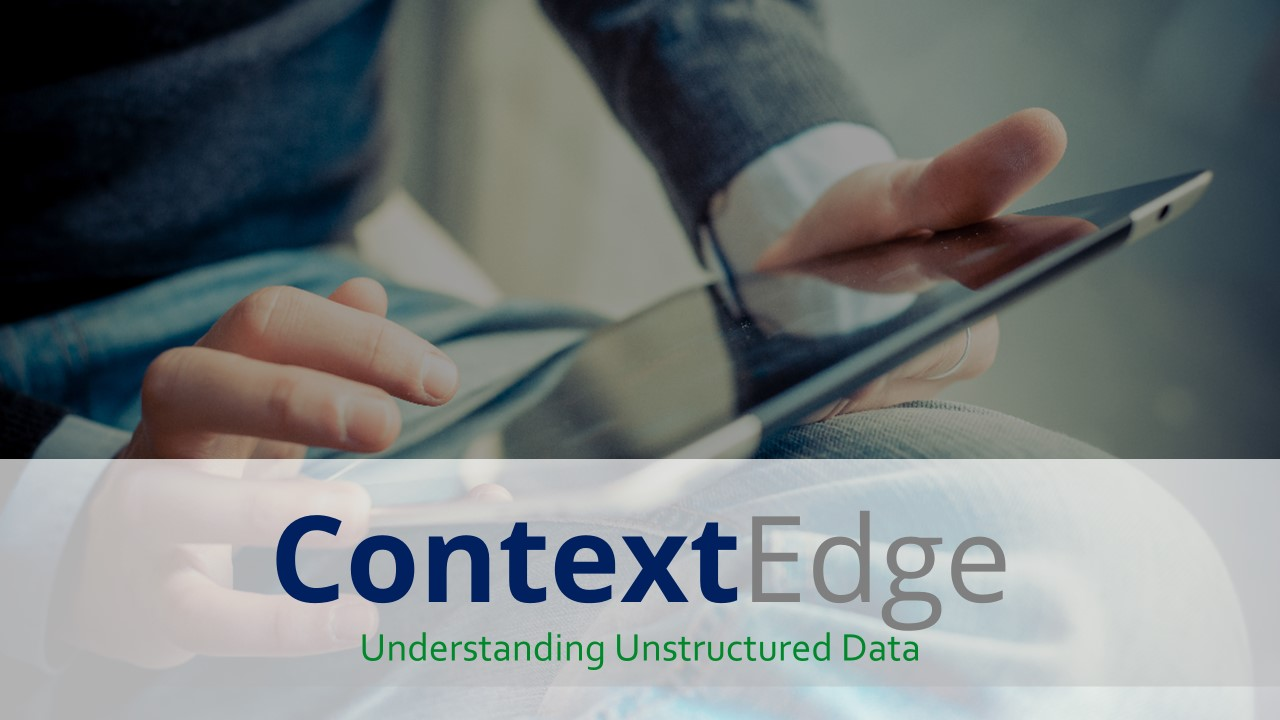

In [4]:
from IPython.display import Image
Image("contextedge.jpg")

# How well can Deloitte's Context Edge learn to classify your emails?

#### <i>Tip: put your cursor in each code snippet box and press shift-enter to execute. Pay attention to the output of each step, checking for errors.</i>

## Step 1: Go to correct directory and activate the DOTCE virtual env

In [2]:
#Replace the directory string in line 3
#with your own directory path where you stored your email files.
%cd c:\Users\pviechnicki\Desktop\pviechnicki_home\sandbox\state\classify
%pwd
! activate dotce

c:\Users\pviechnicki\Desktop\pviechnicki_home\sandbox\state\classify


## Step 2: Load various machine learning libraries to extract features from text document corpus and build classification models

In [3]:
import pandas as pd
import os
import numpy as np
import sys
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pickle
from nltk.probability import FreqDist, ConditionalFreqDist
from collections import defaultdict
import operator #Used to sort dictionaries
from sklearn import metrics

C:\Users\pviechnicki\AppData\Local\Continuum\Anaconda3\envs\dotce\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Step 3: Read csv file of emails into df and split into training and test sets

#### <i>Tip: make sure you've exported 5-7 email folders from outlook as CSV files, then edit stack_email_files.py to reflect the names of the folders you've exported, then execute stack_email_files.py to create combined_emails.csv before running step 3. The path of your combined emails file needs to match what is in line 3 of step 3 below.

In [4]:
#Make sure we're in the right directory
os.getcwd()
email_df = pd.read_csv('C:\\Users\\pviechnicki\\Desktop\\pviechnicki_home\\sandbox\\state\\data\\pv_email\\combined_emails.csv', sep='|')
#Add rowid
email_df['rownum'] = range(0, len(email_df))
email_df.groupby('cat').count()
# Filter out empty rows
non_empty_df = email_df[email_df['body'].isnull() == False].sample(frac=.9)
#sample method chooses a random sample of the origina frame
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
print("Original dataframe contains {} messages\nNon-empty datafram contains {} messages\n".format(
len(email_df), len(non_empty_df)))

Original dataframe contains 4629 messages
Non-empty datafram contains 4164 messages



###  Step 3A: More data wrangling

In [5]:
#Need a function to split thread into messages
def topMessage(text):
    '''
    return first in list of messages, splitting on delimiter
    '''
    messageDelimiter = ' From:'
    return text.split(messageDelimiter)[0]


#### <i>Tip: change 'about_fraud' and 'fraud_waste_abuse' in the code snippet below to match the folders and categories you've chosen and exported.</i>

In [6]:
#Add new column to dataframe with True if cat == fraud_waste_abuse
#Edit the column names and truth conditions to match your data
non_empty_df['about_fraud'] = (non_empty_df['cat'] == 'fraud_waste_abuse')
#Create a vector of class labels
class_labels = non_empty_df['about_fraud']
#use value_counts() method of series
class_labels.value_counts()
#Create derived column with subject + body
non_empty_df['topMessage'] = non_empty_df['body'].apply(topMessage)
non_empty_df['wholeMessage'] = (non_empty_df['subject'] + ' ' + non_empty_df['topMessage'])


In [7]:
#Create a training set and test set, 80% 20%
train_df, test_df = train_test_split(non_empty_df, train_size = 0.8, random_state=44)
class_labels_training = list(train_df['about_fraud'])
class_labels_test = list(test_df['about_fraud'])
value_counts = nltk.FreqDist(class_labels_training)


## Step 4: Add domain-specific words to stop-word list

In [8]:
email_stopwords = ['http', 'bishop', 'eggers', 'pulkit', 'kapoor', 'dupress', 
                   'deloitte', 'mumbai', 'peter', 'viechnicki', 'arlington', 'www', 'com',
                  'mkelkar', 'wegger', 'pviechnicki', 'mailto', 'sent', 'subject',
                  'mahesh', 'https', 'troy', 'tbishop', 'jake', 'punzenburger',
                  'pukapoor', 'brien', 'lorenz', 'laura', 'japunzenburg', 'audre', 'blorenze',
                  'stthai', 'migreen', 'danolson', 'jguszcza']
email_stopwords += stopwords.words('english')


## Step 5: Let's make sure we can tokenize these properly and remove stop words
<p>from <a href="http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html">CS Duke.edu</a></p>
<p>Tip: Make sure you've installed the english punctuation and stop words list 
following <a href="http://www.nltk.org/data.html">these instructions.</a> If you've done it right, you'll see a list of ten common words from your first email when you run step 5.
</p>

In [9]:
#Instantiate a stemmer and a tokenizer to preprocess the email text

snowballStemmer = SnowballStemmer("english", ignore_stopwords=True)
def preprocess(text):
    no_punctuation_text = ''
    if (type(text)== str):
        lower_text = text.lower()
        no_punctuation_text = lower_text.translate({ord(c):' ' for c in string.punctuation})
    return no_punctuation_text

def myTokenize(text):
    global snowballStemmer
    tokens = []
    cleaned = preprocess(text)
    tokens = nltk.word_tokenize(cleaned)
    filtered = [w for w in tokens if not w in email_stopwords]
    stemmed = [w for w in map(snowballStemmer.stem, filtered)]
    return stemmed
    
tokens = myTokenize(train_df['body'].iloc[0])
count = Counter(tokens)
print(count.most_common(10))

[('us', 23), ('0', 19), ('1', 12), ('robert', 12), ('estim', 11), ('wegger', 11), ('rogoodman', 9), ('rate', 8), ('murbanczyk', 8), ('goodman', 8)]


## Step 6: Select 500 meaningful terms as features

In [10]:
#Need function to calculate chisq for each term
#Then choose terms with highest chisq
def chisq(myTerm, myCondition, myFreqDist, myConditionalFreqDist, N_cat, N):
    N_emails_in_my_condition = N_cat
    N_emails = N
    observed = myConditionalFreqDist[myCondition][myTerm]/N_emails_in_my_condition
    expected = myFreqDist[myTerm]/N_emails
    chisq = (observed - expected)**2/expected
    return chisq

In [11]:
fdist = FreqDist()
cfdist = ConditionalFreqDist()
vocabulary = set()
termChisqTableTrue = defaultdict(float)
termChisqTableFalse = defaultdict(float)

N_cat = len(train_df.loc[train_df['about_fraud'] == True])
N = len(train_df)
for index, row in train_df.iterrows():
    subjectTokens = myTokenize(row['subject'])
    bodyTokens = myTokenize(topMessage(row['body']))
    condition = row['about_fraud']
    
    #Store them in regular and conditional frequency distributions
    for token in (subjectTokens + bodyTokens):
        fdist[token] += 1
        cfdist[condition][token] += 1
        vocabulary.add(token)

for term in vocabulary:
    termChisqTableTrue[term] = chisq(term, True, fdist, cfdist, N_cat, N)
    termChisqTableFalse[term] = chisq(term, False, fdist, cfdist, (N-N_cat), N)  

In [12]:
#Select best 5000 features from each condition
bestTermsAndScores = sorted(termChisqTableTrue.items(), key=operator.itemgetter(1), reverse=True)[:100]
bestTerms = [term for (term, chisq) in bestTermsAndScores]

## Step 7: convert train and test dfs to term X document representation matrices (_X)

#### <i>Tip: make sure the circle at top right labeled with the name of your kernerl ('dotce' in my case) turns white, showing that each step has completed, before you move on to the next step.</i>

In [13]:
##Instantiate a TFidf vectorizer
vectorizer = CountVectorizer(encoding='utf-8',tokenizer=myTokenize, vocabulary=bestTerms)

In [14]:
#This step can take a while
train_X = vectorizer.fit_transform(train_df['wholeMessage'].astype('U'))


In [15]:
##Save feature names in a separate list
feature_names = vectorizer.get_feature_names()

In [16]:
#From http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/
#Create another matrix of vectors for the documents in the test set
test_X = vectorizer.transform(test_df['wholeMessage'].astype('U'))

## Step 8: Instantiate and Train a Naive Bayes Classifier

In [17]:
#The alpha value is the sensitivity parameter.
#We train the classifier by feeding it with the labeled training data we created in step 3 above.
model_nb = MultinomialNB(alpha=1)
model_nb.fit(train_X, class_labels_training)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

## Step 9: Test classifier on test_X matrix

### Test NB Classifier results

In [18]:
#First get the predicted class label for each document
predictions = model_nb.predict( test_X )
print("Accuracy score for your classifier: {:.3f}\n".format(model_nb.score( test_X, class_labels_test)))
print("Error rate for your classifier: {:.3f}\n".format(1-model_nb.score( test_X, class_labels_test)))
classifierStats = dict()
classifierStats['accuracy'] = model_nb.score( test_X, class_labels_test)
classifierStats['errorRate'] = (1 - model_nb.score( test_X, class_labels_test))

Accuracy score for your classifier: 0.948

Error rate for your classifier: 0.052



In [24]:
#Also store the predicted class probabilities
predictProbabilities = model_nb.predict_proba( test_X )
predictProbabilities[0]

array([  1.00000000e+00,   5.21672479e-21])

In [27]:
def truth_value(myRow):
    if (myRow['ground_truth'] == True and myRow['predicted_value'] == True):
        return 'truePositive'
    elif (myRow['ground_truth'] == True and myRow['predicted_value'] == False):
        return 'falseNegative'
    elif (myRow['ground_truth'] == False and myRow['predicted_value'] == True):
        return 'falsePositive'
    elif (myRow['ground_truth'] == False and myRow['predicted_value'] == False):
        return 'trueNegative'
    else:
        return None
    
results = [(class_labels_test[i], predictions[i]) for i in range(0,len(predictions))]
#Add in the email id, subject, and body, then truePos, falsePos, trueNeg, falseNeg, posProbability, negProbability
enrichedResults = pd.DataFrame.from_records(results, test_df['rownum'].tolist(), 
    columns = ['ground_truth', 'predicted_value'])
enrichedResults['truthValue'] = enrichedResults.apply(lambda row: truth_value(row), axis=1)
enrichedResults['subject'] = test_df['subject'].tolist()
enrichedResults['body'] = test_df['body'].tolist()
enrichedResults['posProbability'] = [prob[1] for prob in predictProbabilities]
enrichedResults['negProbability'] = [prob[0] for prob in predictProbabilities]
counts = enrichedResults['truthValue'].value_counts()
for i in range(0,len(counts)):
    classifierStats[counts.index[i]] = counts[i]
with open('classifierStats.pyc', 'wb') as f:
    pickle.dump(classifierStats, f)
f.close()
with open('classifierTestResults.pyc', 'wb') as f1:
    pickle.dump(enrichedResults, f1)
f1.close()

In [25]:
model_nb.classes_

array([False,  True], dtype=bool)

## Step 10: Evaluate Results
<p>Nice summary of different formulas for accuracy, precision, recall, etc 
<a href="http://www.damienfrancois.be/blog/files/modelperfcheatsheet.pdf">here</a>.</p>
We're using the sklearn metrics module to evaluate our results.

In [21]:
print(metrics.classification_report(class_labels_test, predictions))
#Need to write this out to persistent object for use by visualizer

             precision    recall  f1-score   support

      False       0.95      0.98      0.96       579
       True       0.95      0.88      0.91       254

avg / total       0.95      0.95      0.95       833



## Step 11: write out most informative features and counts for training set and test set to power dashboard

In [22]:
def mostInformativeFeatures(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = coefs_with_fns[:-(n + 1):-1]
    return(top)
    
        
bestFeatures = mostInformativeFeatures(vectorizer, model_nb, 100)

for (coef, fn) in bestFeatures[0:10]:
        print ("\t{:.4f}\t{}".format(coef, fn))


	-1.9410	us
	-2.5644	fraud
	-2.8702	1
	-2.9645	wast
	-3.2354	program
	-3.6650	error
	-3.6887	interact
	-3.8065	govern
	-3.8167	abus
	-3.9134	tel


In [23]:
# Don't think I need this 
#Count up occurrences of the top 100 most informative features
import csv

def lookupCoef(myTerm, myBestFeatures):
    for (coef, fn) in myBestFeatures:
        if fn == myTerm:
            return(coef)
    return False

with open("termScores.csv", 'wt', encoding='utf8', newline='') as f:
    
    f_csv = csv.writer(f, delimiter=chr(31))
    f_csv.writerow(['term', 'modelCoef', 'posChisq', 'negChisq'])
    
    termNo = 0
    for term in bestTerms:
        termNo += 1
        modelCoef = lookupCoef(term, bestFeatures)
        posChisq = termChisqTableTrue[term]
        negChisq = termChisqTableFalse[term]

        f_csv.writerow([term, modelCoef, posChisq, negChisq])
        if termNo <= 10:
            print("{}|{:.4f}|{:.4f}|{:.4f}".format(term, modelCoef, posChisq, negChisq))

f.close()


fraud|-2.5644|1.7506|0.2972
wast|-2.9645|1.1689|0.1984
abus|-3.8167|0.4974|0.0844
program|-3.2354|0.4841|0.0822
error|-3.6650|0.4305|0.0731
payment|-3.9714|0.4053|0.0688
ai|-8.8037|0.3993|0.0678
ffctn|-4.1216|0.3802|0.0645
improp|-4.2239|0.3398|0.0577
us|-1.9410|0.3300|0.0560
